In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## Import Data

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2023-01-24 09:29:07--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M   840KB/s    in 16s     

2023-01-24 09:29:23 (1.52 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [311]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [79]:
df_books.shape

(271379, 3)

In [80]:
df_ratings.shape

(1149780, 3)

In [5]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [6]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [ ]:
# add your code here - consider creating a new cell for each section of code

## Investigate

In [350]:
user_counts = (
    df_ratings
        .groupby('user', as_index=False)
        .size()
        .sort_values('size', ascending=False)
        .reset_index(drop=True)
        .drop(columns='user')
)

<AxesSubplot:title={'center':'Rating Counts per User'}>

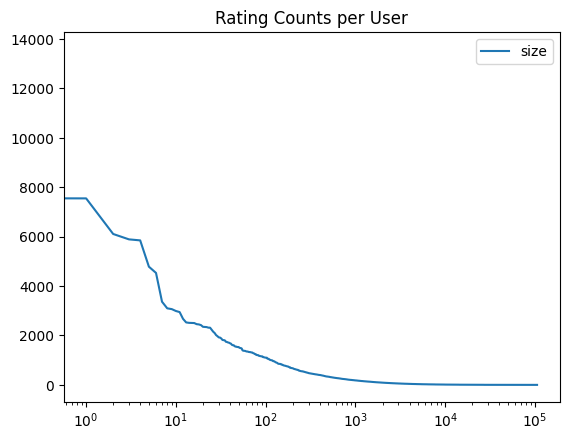

In [353]:
user_counts.plot(kind='line', logx=True, title='Rating Counts per User')

In [ ]:
book_counts = (
    df_ratings
        .groupby('isbn', as_index=False)
        .size()
        .sort_values('size', ascending=False)
        .reset_index(drop=True)
        .drop(columns='isbn')
)

<AxesSubplot:title={'center':'Rating Counts per Book'}>

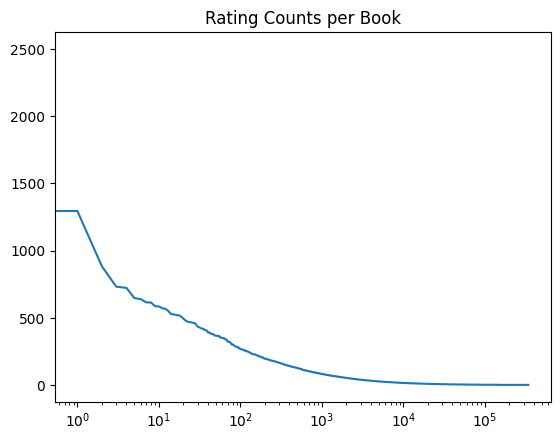

In [356]:
book_counts.plot(kind='line', logx=True, title='Ratings per Book', legend=False)

## Clean Data

### Remove 'orphan' ratings

Some of the ratings don't have a corresponding book record.

_Note:_ I successfully removed them, but it ended up changing the recommendations and causing the test function to fail.

In [241]:
# left join the tables so we can find out which ratings don't have a corresponding book record
df_ratings = df_ratings.merge(df_books, on='isbn', how='left', indicator=True)

In [242]:
df_ratings.head()

,user,isbn,rating,title,author,_merge
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose,both
1,276726,0155061224,5.0,Rites of Passage,Judith Rae,both
2,276727,0446520802,0.0,The Notebook,Nicholas Sparks,both
3,276729,052165615X,3.0,Help!: Level 1,Philip Prowse,both
4,276729,0521795028,6.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,both


So we have 118,605 ratings without a corresponding book & title. 

### Remove ratings for users with <200 and books with <100

In [196]:
# try same thing with a mask
user_mask = df_ratings.groupby('user')['rating'].transform('size') >= 200
book_mask = df_ratings.groupby('isbn')['rating'].transform('size') >= 100
df_ratings_4 = df_ratings[user_mask & book_mask]

In [197]:
df_ratings_4.shape

(49781, 3)

In [198]:
df_ratings_4['isbn'].nunique()

731

In [199]:
df_ratings_4['user'].nunique()

888

### Check for duplicate book titles

In [240]:
df_books.duplicated('title').sum()

29225

## Build and train the model

In [200]:
# shape the data into a matrix with rows for books and columns for users
df_pivot = df_ratings_4.pivot(index='isbn', columns='user', values='rating').fillna(0)
df_pivot.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
# Create a sparse matrix
ratings_matrix = csr_matrix(df_pivot.values)

In [202]:
# create the model
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

In [203]:
# fit the model
model.fit(ratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

## Model2: deduplicate movies

In [ ]:
# join books to add the title to the ratings table
# remove those without matches
# pivot_table with movie title as the index and userid as the columns, and mean as the aggfunc

## Mapping between movie title and index

We need to be able to...

1. map from a movie title we want recommendations for
2. map from indexes returned back to movie titles

How?

1. take index from the pivot and join to movies
2. set title to isbn for those without a match
3. use enumerate to create a map like `{'movie_title': index}`

In [256]:
# get pivot index
isbn_index = df_pivot.index.to_frame().drop(columns='isbn')

In [258]:
df_map = isbn_index.merge(df_books, how='left', on='isbn', indicator=True)

In [300]:
df_map = (
    df_pivot.index
        .to_frame()
        .reset_index(drop=True)
        .merge(df_books, how='left', on='isbn')
)

In [259]:
df_map.head()

,isbn,title,author,_merge
0,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,both
1,0060008032,Angels,Marian Keyes,both
2,0060096195,The Boy Next Door,Meggin Cabot,both
3,006016848X,"Men Are from Mars, Women Are from Venus: A Pra...",John Gray,both
4,0060173289,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,both


In [260]:
df_map._merge.value_counts()

both          727
left_only       4
right_only      0
Name: _merge, dtype: int64

In [270]:
df_map[df_map['title'].isna()]

,isbn,title,author,_merge
42,0091867770,NaN,NaN,left_only
523,0552124753,NaN,NaN,left_only
642,0679781587,NaN,NaN,left_only
673,0749397543,NaN,NaN,left_only


In [299]:
# check duplicated titles
print(f'found {df_map.duplicated("title").sum()} duplicated titles')
df_map[df_map.duplicated('title', keep=False)]

found 54 duplicated titles


,isbn,title,author,_merge
11,0060915544,The Bean Trees,Barbara Kingsolver,both
34,0061097314,The Bean Trees,Barbara Kingsolver,both
54,014028009X,Bridget Jones's Diary,Helen Fielding,both
55,0140293248,The Girls' Guide to Hunting and Fishing,Melissa Bank,both
58,014100018X,Chocolat,Joanne Harris,both
...,...,...,...,...
667,074343627X,Dreamcatcher,Stephen King,both
671,0743460529,Daddy's Little Girl,Mary Higgins Clark,both
672,0743467523,Dreamcatcher,Stephen King,both
678,076790592X,"Tuesdays with Morrie: An Old Man, a Young Man,...",Mitch Albom,both


In [276]:
# set empty titles to the isbn
mask = df_map['title'].isna()
df_map.loc[mask, 'title'] = df_map.loc[mask, 'isbn']

In [277]:
mapper = df_map['title'].to_dict()# Create a dict mapping index to book name
index_to_name_map = df_map['title'].to_dict()

# Create a dict mapping book names to indexes
name_to_index_map = {v: k for k, v in index_to_name_map.items()}

In [279]:
reverse_mapper = {v: k for k, v in mapper.items()}

In [281]:
reverse_mapper['The Boy Next Door']

2

In [305]:
# Create a dict mapping index to book name
index_to_book_map = df_map['title'].to_dict()

In [307]:
# Create a dict mapping book names to indexes
book_to_index_map = {v: k for k, v in index_to_book_map.items()}

In [290]:
df_map[df_map.title == 'The Golden Compass (His Dark Materials, Book 1)']

,isbn,title,author,_merge
163,0345413350,"The Golden Compass (His Dark Materials, Book 1)",PHILIP PULLMAN,both


In [310]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
    # get the corresponding row from the matrix
    index = book_to_index_map[book]
    matrix_row = ratings_matrix[index]
    
    # get recommendations
    distances, indices = model.kneighbors(matrix_row, n_neighbors=6)
    
    recommended_books = []
    
    # loop through results and assemble in the format ["book title", distance]
    for (d, i) in zip(distances[0], indices[0]):
        recommended_books.append([get_name(i), d])
        
    # remove the first (closest) recommendation, which will be the book itself
    recommended_books.pop(0)
    
    # reverse the list
    recommended_books.reverse()
    
    return [book, recommended_books]

## Testing

In [309]:
get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")

["Where the Heart Is (Oprah's Book Club (Paperback))",
 [["I'll Be Seeing You", 0.8016211],
  ['The Weight of Water', 0.77085835],
  ['The Surgeon', 0.7699411],
  ['I Know This Much Is True', 0.7677075],
  ['The Lovely Bones: A Novel', 0.7234864]]]

In [291]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

Getting recommendations for The Queen of the Damned (Vampire Chronicles (Paperback)) (index 137)


['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412]]]

In [289]:
get_recommends('The Golden Compass (His Dark Materials, Book 1)')

Getting recommendations for The Golden Compass (His Dark Materials, Book 1) (index 163)


['The Golden Compass (His Dark Materials, Book 1)',
 [['Moo', 0.83690083],
  ['The Door to December', 0.8296318],
  ["The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure",
   0.81454146],
  ['Lake Wobegon days', 0.8100381],
  ['Me Talk Pretty One Day', 0.7856666]]]

In [237]:
get_index('0345413350')

163

In [304]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    print('0th element is incorrect')
    test_pass = False
  recommended_books = ["I'll Be Seeing You", "The Weight of Water", "The Surgeon", "I Know This Much Is True", "The Lovely Bones: A Novel"]
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77, 0.72]
  for i, (book, distance) in enumerate(zip(recommended_books, recommended_books_dist)):
    if recommends[1][i][0] != book:
      print(f'Book {i} should be {book}, but found {recommends[1][i][0]}')
      test_pass = False
      break
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      print(f'Distance {i} should be {distance}, but found {recommends[1][i][1]}')
      test_pass = False
      break
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
